In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import numpy as np
import pandas as pd

### General Function

In [29]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

### Load Datasets

In [88]:
datasets_df = pd.read_csv('../data/datasets/datasets.csv')
X = datasets_df['Payloads'].to_numpy().astype(str)
y = datasets_df['Types'].to_numpy().astype(str)

### Split Data

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [90]:
np.savez('../data/datasets/dataset', trainX=X_train, testX=X_test, trainY=y_train, testY=y_test)

## SVM
### Grid Search for Hyperameter Tuning SVM

In [15]:
pipe = make_pipeline(TfidfVectorizer(input = 'content', lowercase = True, analyzer = 'char', max_features = 1024), SVC())

grids = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 4)], 
    'svc__C': [1, 10], 
    'svc__kernel': ['linear', 'rbf']
}

grid = GridSearchCV(pipe, grids, cv = 2, verbose = 4)

grid.fit(X_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2] END svc__C=1, svc__kernel=linear, tfidfvectorizer__ngram_range=(1, 1);, score=0.988 total time=   4.7s
[CV 2/2] END svc__C=1, svc__kernel=linear, tfidfvectorizer__ngram_range=(1, 1);, score=0.988 total time=   4.4s
[CV 1/2] END svc__C=1, svc__kernel=linear, tfidfvectorizer__ngram_range=(1, 2);, score=0.994 total time=  18.2s
[CV 2/2] END svc__C=1, svc__kernel=linear, tfidfvectorizer__ngram_range=(1, 2);, score=0.992 total time=  18.0s
[CV 1/2] END svc__C=1, svc__kernel=linear, tfidfvectorizer__ngram_range=(1, 4);, score=0.994 total time=  20.8s
[CV 2/2] END svc__C=1, svc__kernel=linear, tfidfvectorizer__ngram_range=(1, 4);, score=0.993 total time=  21.6s
[CV 1/2] END svc__C=1, svc__kernel=rbf, tfidfvectorizer__ngram_range=(1, 1);, score=0.992 total time=   5.8s
[CV 2/2] END svc__C=1, svc__kernel=rbf, tfidfvectorizer__ngram_range=(1, 1);, score=0.990 total time=   5.8s
[CV 1/2] END svc__C=1, svc__kernel=rbf, tfidfvect

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(analyzer='char',
                                                        max_features=1024)),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [1, 10], 'svc__kernel': ['linear', 'rbf'],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 4)]},
             verbose=4)

In [16]:
print("Best score: %0.3f" % grid.best_score_)
print("Best parameters set:")
best_parameters = grid.best_estimator_.get_params()
for param_name in sorted(grids.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Best score: 0.995
Best parameters set:
	svc__C: 10
	svc__kernel: 'rbf'
	tfidfvectorizer__ngram_range: (1, 4)


### Train Model

In [19]:
model_svm = make_pipeline(TfidfVectorizer(input = 'content', lowercase = True, analyzer = 'char', max_features = 1024, ngram_range = (1, 4)), SVC(C = 10, kernel = 'rbf', probability=True))
model_svm.fit(X_train, y_train) 

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='char', max_features=1024,
                                 ngram_range=(1, 4))),
                ('svc', SVC(C=10, probability=True))])

In [20]:
model_svm.score(X_test, y_test)

0.9961990032941972

In [25]:
test_prediction_svm = model_svm.predict(X_test)
test_accuracy_svm = accuracy_score(y_test, test_prediction_svm)

### Classification Report

In [26]:
print("Test Accuracy SVM:", test_accuracy_svm)
print(classification_report(y_test, test_prediction_svm))

Test Accuracy SVM: 0.9961990032941972
              precision    recall  f1-score   support

        crlf       0.95      0.95      0.95        21
         lfi       1.00      1.00      1.00      3973
      normal       1.00      1.00      1.00      4404
       nosql       1.00      0.50      0.67         2
         rfi       1.00      1.00      1.00       455
         sql       1.00      0.97      0.98       412
         ssi       1.00      0.96      0.98        23
        ssti       0.92      0.96      0.94        24
         xss       0.99      0.99      0.99      2508
         xxe       0.67      0.47      0.55        17

    accuracy                           1.00     11839
   macro avg       0.95      0.88      0.91     11839
weighted avg       1.00      1.00      1.00     11839



In [27]:
cf_matrix_svm = confusion_matrix(y_test , test_prediction_svm)
print(cf_matrix_svm)

[[  20    0    0    0    0    0    0    0    1    0]
 [   0 3970    2    0    0    0    0    0    1    0]
 [   0    0 4404    0    0    0    0    0    0    0]
 [   0    0    0    1    0    0    0    0    1    0]
 [   0    0    0    0  454    0    0    0    1    0]
 [   0    0    1    0    0  400    0    0   11    0]
 [   0    0    0    0    0    0   22    0    1    0]
 [   0    0    0    0    0    0    0   23    1    0]
 [   1    2    5    0    0    2    0    2 2492    4]
 [   0    0    0    0    0    0    0    0    9    8]]


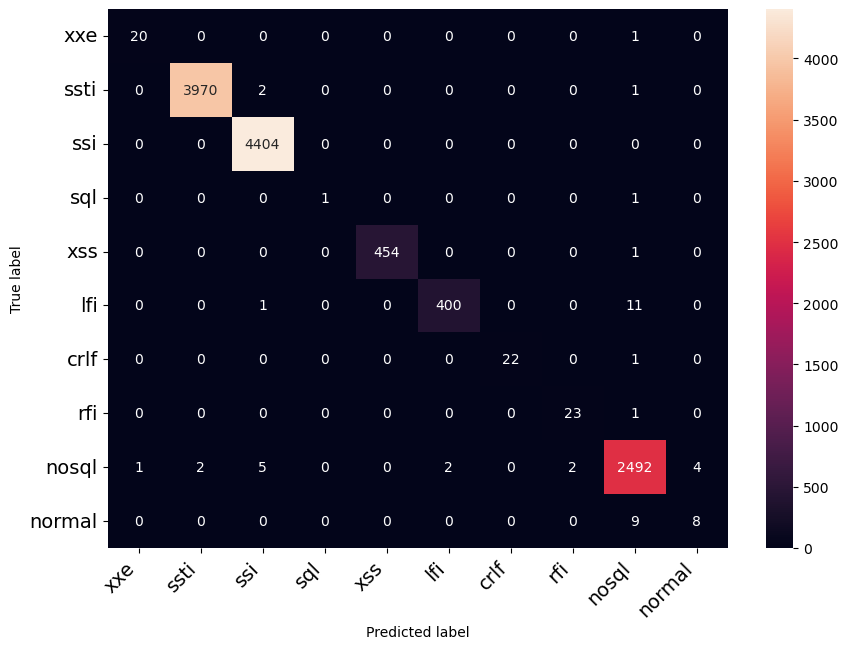

In [32]:
labels = list(set(y_test))
print_confusion_matrix(cf_matrix_svm, class_names=labels);

### Save Model SVM

In [33]:
filename_model_svm = '../models/model_svm.pmal'
pickle.dump(model_svm, open(filename_model_svm, 'wb'))

### Test Model

In [48]:
loaded_model_svm = pickle.load(open(filename_model_svm, 'rb'))

#List of payloads to test
parameters = [
    "%3f%0dshivang:crlf=injection", 
    "query=home&homeprice=4300",
    "perPage=10",
    "#shivang",
    "<pre><!--#exec cmd=\"id\"--></pre>",
    "../\\\\\\../\\\\\\../\\\\\\etc/passwd%00%00", 
    "query=shivang)))' OR 1=2#-- -", 
    "something;|id|", 
    "{$gt: ''}",
    "<img src=x onerror=\"&#0000106&#0000097&#0000118&#0000097&#0000115&#0000099&#0000114&#0000105&#0000112&#0000116&#0000058&#0000097&#0000108&#0000101&#0000114&#0000116&#0000040&#0000039&#0000088&#0000083&#0000083&#0000039&#0000041\">",
    "1' ORDER BY 1,2,3--+"
]

temp_array = []

#Function acts as backend for payload detection
def run_svm(parameters, temp_array):
  for detect in range(len(parameters)):
    temp_array.append(parameters[detect])
    prediction = loaded_model_svm.predict(temp_array)
    confidence_scores = 100*(np.round(loaded_model_svm.predict_proba(temp_array), 3))
      
    if "normal" in prediction:
      print("\n[+] You can access our site!\n", parameters[detect])
    else:
      print("[!] Attack detected!")
      for result in prediction:
        print(f"[~] Attack type", result)
    temp_array = []

In [49]:
run_svm(parameters, temp_array)

[!] Attack detected!
[~] Attack type crlf

[+] You can access our site!
 query=home&homeprice=4300

[+] You can access our site!
 perPage=10
[!] Attack detected!
[~] Attack type xss
[!] Attack detected!
[~] Attack type ssi
[!] Attack detected!
[~] Attack type lfi
[!] Attack detected!
[~] Attack type sql
[!] Attack detected!
[~] Attack type xss
[!] Attack detected!
[~] Attack type nosql
[!] Attack detected!
[~] Attack type xss
[!] Attack detected!
[~] Attack type sql


## KNN
### Grid Search for Hyperameter Tuning KNN

In [100]:
pipe = make_pipeline(
    TfidfVectorizer(input = 'content', lowercase = True, analyzer = 'char', max_features = 1024), 
    KNeighborsClassifier()
)

kf=KFold(n_splits=2, shuffle=True, random_state=42)

parameter_grid_knn = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 4)],
    'kneighborsclassifier__n_neighbors': np.arange(2, 30, 1)
}

In [101]:
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(pipe, param_grid=parameter_grid_knn, cv=kf, verbose=4)
knn_cv.fit(X_train, y_train)

Fitting 2 folds for each of 84 candidates, totalling 168 fits
[CV 1/2] END kneighborsclassifier__n_neighbors=2, tfidfvectorizer__ngram_range=(1, 1);, score=0.986 total time=  23.9s
[CV 2/2] END kneighborsclassifier__n_neighbors=2, tfidfvectorizer__ngram_range=(1, 1);, score=0.989 total time=  23.7s
[CV 1/2] END kneighborsclassifier__n_neighbors=2, tfidfvectorizer__ngram_range=(1, 2);, score=0.983 total time= 3.2min
[CV 2/2] END kneighborsclassifier__n_neighbors=2, tfidfvectorizer__ngram_range=(1, 2);, score=0.926 total time= 3.3min
[CV 1/2] END kneighborsclassifier__n_neighbors=2, tfidfvectorizer__ngram_range=(1, 4);, score=0.984 total time= 3.8min
[CV 2/2] END kneighborsclassifier__n_neighbors=2, tfidfvectorizer__ngram_range=(1, 4);, score=0.945 total time= 3.8min
[CV 1/2] END kneighborsclassifier__n_neighbors=3, tfidfvectorizer__ngram_range=(1, 1);, score=0.987 total time=  23.5s
[CV 2/2] END kneighborsclassifier__n_neighbors=3, tfidfvectorizer__ngram_range=(1, 1);, score=0.990 total

KeyboardInterrupt: 

In [ ]:
print(knn_cv.best_params_)

In [ ]:
# print(knn_cv.best_params_)
print("Best score: %0.3f" % knn_cv.best_score_)
print("Best parameters set:")
best_parameters = knn_cv.best_estimator_.get_params()
for param_name in sorted(parameter_grid_knn.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
### Train Model

In [ ]:
model_knn = make_pipeline(TfidfVectorizer(input = 'content', lowercase = True, analyzer = 'char', max_features = 1024, ngram_range = (1, 4)), KNeighborsClassifier(n_neighbors = 10))
model_knn.fit(X_train, y_train) 

In [ ]:
model_knn.score(X_test, y_test)

In [ ]:
test_prediction_knn = model_knn.predict(X_test)
test_accuracy_knn = accuracy_score(y_test, test_prediction_knn)
print("Test Accuracy KNN:", test_accuracy_knn)

### Classification Report

In [ ]:
print(classification_report(y_test, test_prediction_knn))

In [ ]:
cf_matrix_knn = confusion_matrix(y_test , test_prediction_knn)
print(cf_matrix_knn)

In [ ]:
labels = list(set(y_test))
print_confusion_matrix(cf_matrix_knn, class_names=labels);

### Save Model KNN

In [ ]:
filename_model_knn = '../models/model_knn.pmal'
pickle.dump(model_knn, open(filename_model_knn, 'wb'))